# Plotting communities

Communities are created in Neo4j using various communit detection algorithms. The results of these algorithms are stored in the database as a property of the nodes. This notebook shows how to plot these communities using the Neo4j graph algorithms library.

In [2]:
from databaseconnection import DatabaseConnection
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

gds = DatabaseConnection().get_database_connection()
gds.version()


'2.3.2'

### Query data from Neo4j

First we need to connect to the Neo4j database and query the data we want to plot. The data will be stored in a pandas dataframe.

In [3]:
students = gds.run_cypher("MATCH (student:Student) RETURN student")["student"]

print("Number of students: ", len(students))
print(students)

# Convert the respondents Series to a DataFrame
students_data = []
for student in students:
    students_data.append({'id': student['id'], 'normalityIndex': student["normalityIndex"], 'louvainId_pos_prop': str(student["louvainId_pos_prop"]),
                          'lpaId_pos_prop': str(student['lpaId_pos_prop']), 'louvainId_similarity_pos_prop': str(student['louvainId_similarity_pos_prop']),
                          'lpaId_similarity_pos_prop': str(student['lpaId_similarity_pos_prop'])})

df = pd.DataFrame(students_data)

print(df)


Number of students:  3039
0       (louvainId_similarity_pos_prop, normalityIndex...
1       (louvainId_similarity_pos_prop, normalityIndex...
2       (louvainId_similarity_pos_prop, normalityIndex...
3       (louvainId_similarity_pos_prop, normalityIndex...
4       (louvainId_similarity_pos_prop, normalityIndex...
                              ...                        
3034    (louvainId_similarity_pos_prop, normalityIndex...
3035    (louvainId_similarity_pos_prop, normalityIndex...
3036    (louvainId_similarity_pos_prop, normalityIndex...
3037    (louvainId_similarity_pos_prop, normalityIndex...
3038    (louvainId_similarity_pos_prop, normalityIndex...
Name: student, Length: 3039, dtype: object
                                        id  normalityIndex louvainId_pos_prop  \
0     8931d1bb-ecf8-4031-82c9-5de135419799        0.473539                720   
1     60ff73a9-822e-439e-a47e-37e0a7621c1c        0.453208                718   
2     adbd7cd8-d1a7-4058-9645-c0147709a04c        

### Plotting Louvain communities

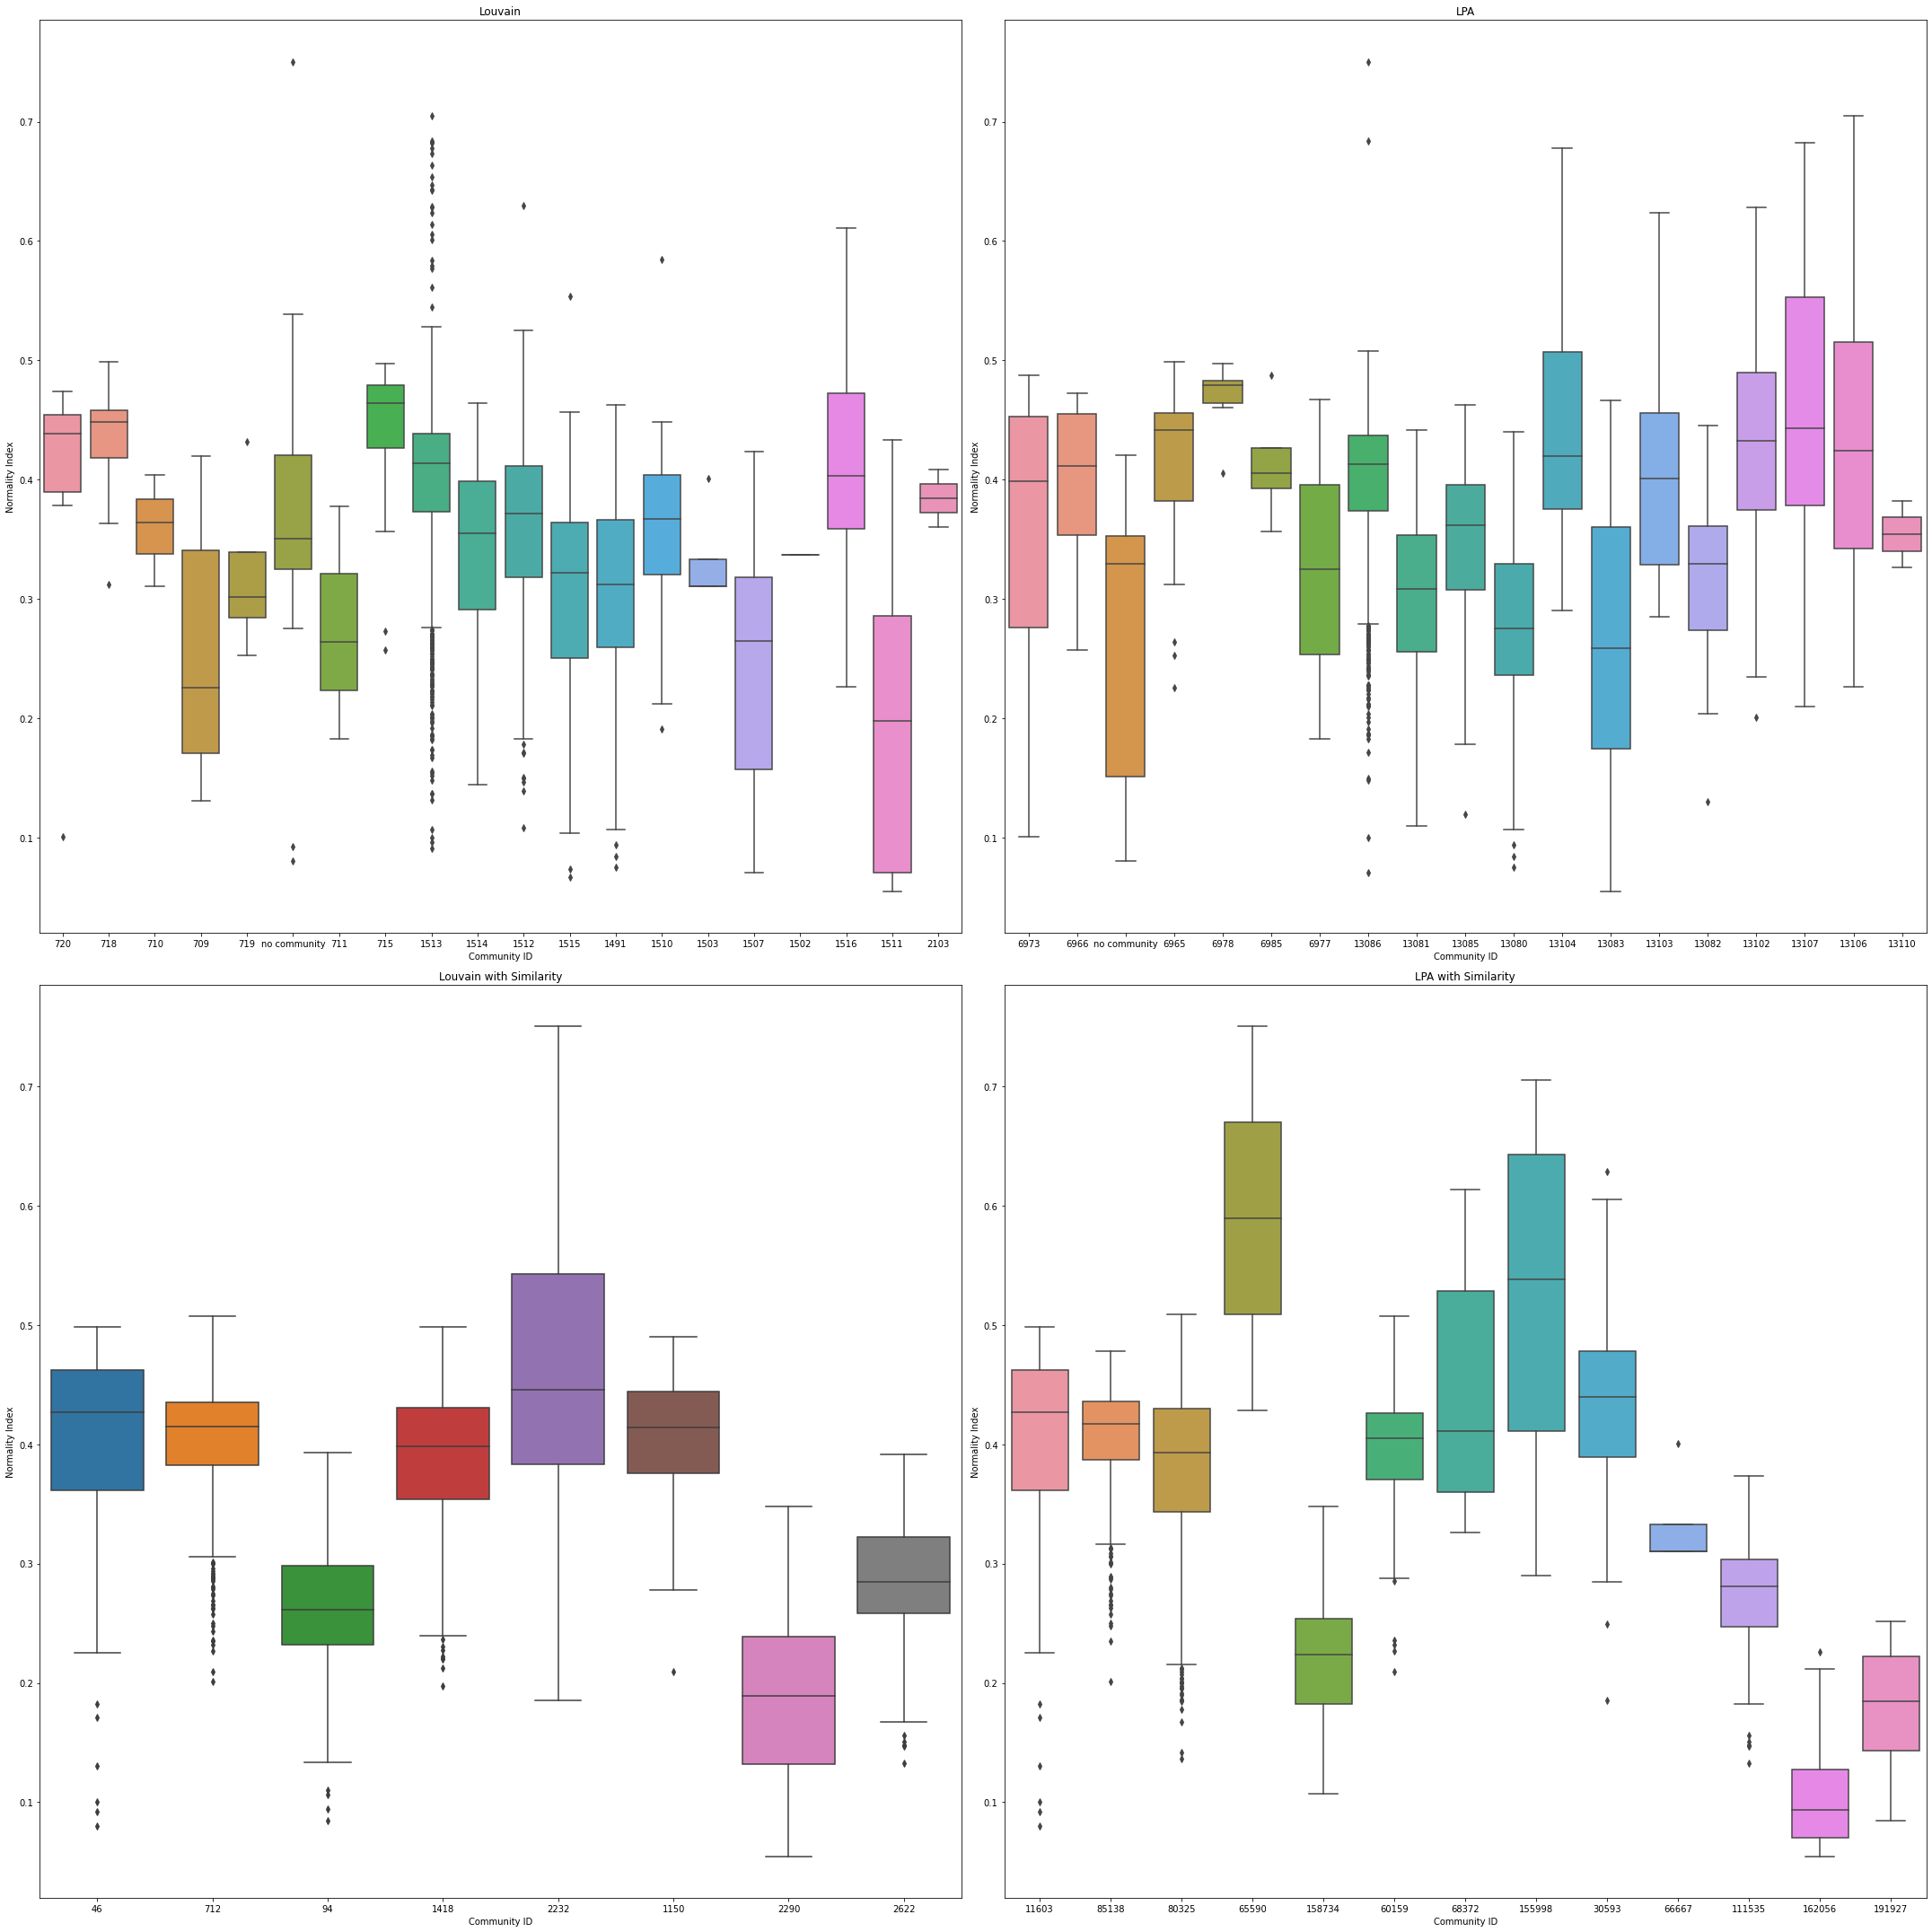

In [14]:

data = df

def create_new_community(data, community_column, min_community_size):
    # Get the number of students in each community
    community_sizes = data[community_column].value_counts()

    # Get the communities with less than 2 students
    small_communities = community_sizes[community_sizes < min_community_size]

    # Create a new community for all students in the small communities
    data.loc[data[community_column].isin(
        small_communities.index), community_column] = 'no community' if min_community_size == 2 else 'small community'

    return data

# Create a community for all students in communities with less than 2 students. Move all students in these communities to the new community. Do this for each of the three community detection algorithms.
# This is done to make the plot more readable.
data = create_new_community(data, 'louvainId_pos_prop', 2)
data = create_new_community(data, 'lpaId_pos_prop', 2)
data = create_new_community(data, 'louvainId_similarity_pos_prop', 2)
data = create_new_community(data, 'lpaId_similarity_pos_prop', 2)

# Remove `no community` from `louvainId_similarity_pos_prop` and `lpaId_similarity_pos_prop`
data = data[data['louvainId_similarity_pos_prop'] != 'no community']
data = data[data['lpaId_similarity_pos_prop'] != 'no community']

# Set up a 4x4 grid for your visualizations
SIZE = 15
# Set up the grid layout
fig, axes = plt.subplots(2, 2, figsize=(2 * SIZE, 2 * SIZE))

# Box plots
sns.boxplot(data=data, x='louvainId_pos_prop', y='normalityIndex', ax=axes[0, 0]).set(
    xlabel='Community ID', ylabel='Normality Index', title='Louvain')
sns.boxplot(data=data, x='lpaId_pos_prop', y='normalityIndex', ax=axes[0, 1]).set(
    xlabel='Community ID', ylabel='Normality Index', title='LPA')
sns.boxplot(data=data, x='louvainId_similarity_pos_prop', y='normalityIndex', ax=axes[1, 0]).set(
    xlabel='Community ID', ylabel='Normality Index', title='Louvain with Similarity')
sns.boxplot(data=data, x='lpaId_similarity_pos_prop', y='normalityIndex', ax=axes[1, 1]).set(
    xlabel='Community ID', ylabel='Normality Index', title='LPA with Similarity')

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()


### Export results from plots to spreadsheet

In [17]:
# Export the communities to the spreadsheet results/spreadsheet_bjorn.xlsx. 
# The spreadsheet already contains sheets `Respondent` and `Question`.
# `Respondent` contains columns `respondent.id` and `question.name` with values `questionAlternative.name` for each respondent.
# `Question` contains columns `question.name` and `questionAlternative.name` with values `respondent.id` for each question.
# The sheet was generated using the following code:
# # Create Respondent dataframe
# respondent_df = result.pivot_table(index='respondent.id', columns='question.name', values='questionAlternative.name', aggfunc='first').reset_index()
#
# # Create Question dataframe
# question_df = result[['question.id', 'question.name', 'questionAlternative.id', 'questionAlternative.name', 'questionAlternative.position']].drop_duplicates()
#
# # Export to Excel
# with pd.ExcelWriter('output.xlsx') as writer:
#     respondent_df.to_excel(writer, index=False, sheet_name='Respondent')
#     question_df.to_excel(writer, index=False, sheet_name='Question')

# Export the communities to the spreadsheet results/spreadsheet_bjorn.xlsx.
# One sheet for each Communit ID.
# Each sheet should contain columns `respondent.id`, `normalityIndex` and `question.name` with corresponding `questionAlternative.name` as values.
# Respondent is student in this case.

# Query Students and their QuestionAlternatives and their Question
result = gds.run_cypher("""
                MATCH (student:Student)-[:CHOSE_ALT]->(questionAlternative:QuestionAlternative)<-[:CONSISTS_OF]-(question:Question)
                RETURN student.id, questionAlternative.name, question.name
                ORDER BY student.id, question.name
               """)


In [22]:

# Create CommunityId dataframes. One for each community ID.
community_ids = data['louvainId_pos_prop'].unique()
for community_id in community_ids:
    # Filter out students not in the community
    community_df = data[data['louvainId_pos_prop'] == community_id]

    # Merge the community dataframe with the result dataframe
    community_df = pd.merge(community_df, result, left_on='id', right_on='student.id')
  
    # Export to Excel
    with pd.ExcelWriter('output.xlsx', mode='a') as writer:
        community_df.to_excel(writer, index=False, sheet_name='Louvain Community ' + str(community_id))

#TODO: Do this for the other community detection algorithms as well.